## Section 5.1: Star formation function and the SFRD

In [1]:
from functools import partial
import numpy as np
import h5py
from unyt import Msun, Myr, Angstrom, erg, s, Hz
from astropy.cosmology import LambdaCDM
import pandas as pd
from schwimmbad import MultiPool
from uncertainties import unumpy
from scipy import integrate

from synthesizer.grid import Grid
from synthesizer.particle import Galaxy
from synthesizer.instruments.filters import FilterCollection

from synthesizer.emission_models import PacmanEmission
from synthesizer.emission_models.attenuation import PowerLaw, Calzetti2000, GrainModels
from synthesizer.emissions.utils import (
    Ha,
    Hb, 
)
from synthesizer.conversions import lnu_to_absolute_mag

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cmasher as cmr

from lmfit import Model

from utilities import calc_line_corr, calc_line_corr_from_Av, get_flares_LF

cosmo = LambdaCDM(Om0=0.307, Ode0=0.693, H0=67.77, Ob0=0.04825)
plt.style.use('styles/style.mplstyle')

# Set the random seed for reproducibility
np.random.seed(680010)

In [2]:
def Ha_to_SFR(Ha):
    """Convert Halpha to SFR using the Kennicut relation.
    
    Args:
        Ha (float): The Halpha luminosity in erg/s.
        
    Returns:
        sfr (float): The star formation rate in Msun/yr.
    """
    
    sfr = 10**(-41.36) * Ha
    
    return sfr

def get_data(ii, tag):
    """Helper function to retreive FLARES data relevant for this notebook.
    
    Args:
        ii (int): The index of the galaxy to load.
        tag (str): The tag of the simulation to load.
    
    Returns:
        Mstar (float): The stellar mass of the galaxy in Msun.
        MFUVatt (float): The observed FUV luminosity of the galaxy in erg/s/Hz.
        Halpha (float): The observed Halpha luminosity of the galaxy in erg/s.
        Hbeta (float): The observed Hbeta luminosity of the galaxy in erg/s.
        Halphaint (float): The intrinsic Halpha luminosity of the galaxy in erg/s.
        Hbetaint (float): The intrinsic Hbeta luminosity of the galaxy in erg/s.
        MassweightedZ (float): The mass-weighted metallicity of the galaxy.
        MFUVint (float): The intrinsic FUV luminosity of the galaxy in erg/s/Hz.
        Av (float): The V-band attenuation of the galaxy in magnitudes.
        SFR10 (float): The star formation rate of the galaxy averaged over the last 10 Myr in Msun/yr.
    """

    num = str(ii)

    if len(num) == 1:
        num =  '0'+num

    sim = "./data/flares_shared_data.hdf5"
    num = num+'/'

    with h5py.File(sim, 'r') as hf:
        Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
        SFR10   = np.array(hf[num+tag+'/Galaxy/SFR_aperture/30'].get('10Myr'), dtype = np.float32)
        
        MassweightedZ = np.array(hf[num+tag+'/Galaxy/Metallicity'].get('CurrentMassWeightedStellarZ'), dtype = np.float32)
        MFUVatt = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Luminosity/DustModelI'].get('FUV'), dtype = np.float32) * erg / s / Hz
        MFUVint = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Luminosity/Intrinsic'].get('FUV'), dtype = np.float32) * erg / s / Hz

        Av = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Luminosity/DustModelI'].get('V'), dtype = np.float32) / np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Luminosity/Intrinsic'].get('V'), dtype = np.float32)
        Av = -2.5 * np.log10(Av)

        Halpha = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/HI6563'].get('Luminosity'), dtype = np.float64)
        Hbeta = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/HI4861'].get('Luminosity'), dtype = np.float64)
        Halphaint = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/Intrinsic/HI6563'].get('Luminosity'), dtype = np.float64)
        Hbetaint = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/Intrinsic/HI4861'].get('Luminosity'), dtype = np.float64)      

    ok = (Halphaint>0) * (lnu_to_absolute_mag(MFUVatt)<-17)

    return Mstar[ok], MFUVatt[ok], Halpha[ok], Hbeta[ok], Halphaint[ok], Hbetaint[ok], MassweightedZ[ok], MFUVint[ok], Av[ok], SFR10[ok]

In [3]:
def schechter_fn(logL, logLstar, logphistar, alpha):
    """Schechter function in logspace.
    
    Args:
        logL (float or np.array): The log of the luminosity (or mass) at which to evaluate the function.
        logLstar (float): The log of the characteristic luminosity (or mass) where the function transitions from a power-law to an exponential cutoff.
        logphistar (float): The log of the normalization factor (number density at L*).
        alpha (float): The faint-end slope of the function.
        
    Returns:
        log_phi (float or np.array): The log of the number density (dn/dlogL) at the given logL.
    """
    # 10**(logL - logLstar) is M/M*
    # The Schechter function in log-form:
    # Phi_log(M) = ln(10) * phi* * (M/M*)^(alpha+1) * exp(-M/M*)
    
    # Calculate terms
    term1 = logphistar
    term2 = (logL - logLstar) * (alpha + 1)
    
    term3 = np.log10(np.log(10)) - (10**(logL - logLstar) * np.log10(np.e))
    
    return term1 + term2 + term3

def calculate_sfr_density(logphi, logLgrid):
    """Integrate to find Total SFR Density.
    rho = Integral(M * Phi(M) dlogM)
    
    Args:
        logphi (np.array): The log of the number density (dn/dlogM) evaluated at the logLgrid points.
        logLgrid (np.array): The log of the luminosity (or mass) grid points at which logphi is evaluated.  
        
    Returns:
        rho (float): The integrated SFR density in Msun/yr/Mpc^3
    """
    phi = 10**logphi     # This is dn / dlogM
    M = 10**logLgrid     # This is Mass
    
    # Integrand = SFR * NumberDensity
    # We integrate over dlogM (which simpson handles via x=logLgrid)
    integrand = M * phi 
    
    # Integrate using Simpson's rule
    rho = integrate.simpson(y=integrand, x=logLgrid, axis=1)
    
    return rho

def draw_schechter_samples(N, mu, cov):
    """Draw N Monte-Carlo samples for [logL*, logphistar, alpha].
    
    Args:
        N (int): The number of samples to draw.
        mu (array-like): The mean vector for the multivariate normal distribution, ordered as [logLstar, logphistar, alpha].
        cov (array-like): The covariance matrix for the multivariate normal distribution, ordered as [logLstar, logphistar, alpha].
    
    Returns:
        logLstar_s (np.array): An array of shape (N,) containing the sampled logL* values.
        logphistar_s (np.array): An array of shape (N,) containing the sampled logphistar values.
        alpha_s (np.array): An array of shape (N,) containing the sampled alpha values.
    """
    # mu and cov must follow the order: logLstar, logphistar, alpha
    samples = np.random.multivariate_normal(mu, cov, size=N)
    return samples[:,0], samples[:,1], samples[:,2]

def schechter_mass_density_MC(N_MC, mu, cov, logL_min, logL_max, M=40):
    """Compute mean and std of Integrated SFR density using MC.    
    mu vector order must be: [logLstar, logphistar, alpha]
    
    Args:
        N_MC (int): Number of Monte-Carlo samples to draw.
        mu (array-like): The mean vector for the multivariate normal distribution, ordered as [logLstar, logphistar, alpha].
        cov (array-like): The covariance matrix for the multivariate normal distribution, ordered as [logLstar, logphistar, alpha].
        logL_min (float): The minimum log luminosity (or mass) to consider in the integration.
        logL_max (float): The maximum log luminosity (or mass) to consider in the integration.
        M (int): The number of points in the logL grid for integration.
        
    Returns:
        mean_rho (float): The mean of the integrated SFR density across the MC samples.
        std_rho (float): The standard deviation of the integrated SFR density across the MC samples.
        rho_samples (np.array): The raw integrated SFR density values for each MC sample, of shape (N_MC,).
    """

    # Draw samples (Order: logLstar, logphistar, alpha)
    logLstar_s, logphistar_s, alpha_s = draw_schechter_samples(N_MC, mu, cov)

    # Build logL grid
    logL_grid = np.linspace(logL_min, logL_max, M)

    # Compute LF for all samples
    # Shape: (N_MC, M)
    log_phi_grid = schechter_fn(
        logL_grid[None, :], 
        logLstar_s[:, None], 
        logphistar_s[:, None], 
        alpha_s[:, None]
    )

    # Integrate Mass Density for every sample
    rho_samples = calculate_sfr_density(log_phi_grid, logL_grid)

    # Return mean, std, and raw samples
    return rho_samples.mean(), rho_samples.std(), rho_samples

def fit_schechter(log_phi, logL, phi_linear, phi_err_linear, fix_alpha=None):
    """Schechter fit using weighted errors.
    
    Args:
        log_phi: np.log10(phi), y-values in log space
        logL: The data x-values in log space
        phi_linear: The linear phi values (needed for error calc)
        phi_err_linear: The Poisson error in linear space
        fix_alpha: If set (float), fixes alpha to this value.
        
    Returns:
        result_mcmc: The result object from the MCMC fit, containing best-fit parameters and uncertainties.
    """
    
    # Calculate Weights for Log-Space Fit
    # Error propagation: d(log10(y)) = dy / (y * ln(10))
    # We add a tiny epsilon to phi_linear to avoid division by zero
    log_err = phi_err_linear / (phi_linear * np.log(10) + 1e-30)
    
    # Lmfit uses weights = 1/sigma. 
    # Clip very small errors to avoid infinite weights dominating the fit.
    weights = 1.0 / (log_err + 1e-10)

    model = Model(schechter_fn)

    # Set some logical bounds based on Data
    # Constrain logLstar to be within reasonable distance of the data max
    max_data_mass = np.max(logL)
    model.set_param_hint('logLstar', min=0.1, max=3.0)
    model.set_param_hint('logphistar', min=-7, max=-2) 

    # Handle alpha constraints
    if fix_alpha is not None:
        model.set_param_hint('alpha', value=fix_alpha, vary=False)
    else:
        model.set_param_hint('alpha', min=-3.5, max=-0.5, vary=True)

    # Make initial parameter object
    params = model.make_params(
        # Guess the knee is near the max data
        logLstar=max_data_mass - 0.5,
        logphistar=np.mean(log_phi), 
        alpha=-1.3
    )

    # "best fit" without MCMC overhead
    result_mle = model.fit(
        log_phi, 
        params, 
        logL=logL, 
        weights=weights,
        method='leastsq', 
        nan_policy='omit'
    )

    # We use the result of above to initialise the walkers for emcee
    # This prevents walkers from getting lost in low-probability areas    
    result_mcmc = model.fit(
        log_phi, 
        result_mle.params, # Start from the MLE result
        logL=logL, 
        weights=weights,
        method='emcee', 
        fit_kws={
            'steps': 4000, 
            'burn': 2000, 
            'nwalkers': 100, 
            'thin': 20, 
            'progress': False
        }, 
        nan_policy='omit'
    )
    
    return result_mcmc

In [4]:
# Define the synthesizer grid
grid_name = "bpass-2.2.1-bin_chabrier03-0.1,300.0_cloudy-c23.01-sps"
grid_dir = "./data/" 
grid = Grid(grid_name, grid_dir=grid_dir)

Zsun = 0.014

# Define the required lines
req_lines = {'H 1 6562.80A': 'Halpha',
             'H 1 4861.32A': 'Hbeta',
             'O 2 3726.03A,O 2 3728.81A': '[OII]3727,29',
             'O 3 4958.91A': '[OIII]4959',
             'O 3 5006.84A': '[OIII]5007',
             'Ne 3 3868.76A': 'NeIII3869',
             'H 1 1.87510m': 'Paalpha',
             'H 1 1.28181m': 'Pabeta',
             'H 1 1.00494m': 'Pagamma'
             
}

# Top hat filters
tophats = {
    "UV1500": {"lam_eff": 1500*Angstrom, "lam_fwhm": 300*Angstrom},
    "UV2800": {"lam_eff": 2800*Angstrom, "lam_fwhm": 300*Angstrom},
}

# Define the filter collection
filters = FilterCollection(
    filter_codes=[f'Generic/Johnson.V'],
    tophat_dict=tophats,
    new_lam=grid.lam
)

# Balmer lines for dust correction
li = [
       Ha,
       Hb, 
   ]

# Wavelength of Balmer lines for dust correction
lam_Ha = 6562.80 * Angstrom
lam_Hb = 4861.32 * Angstrom

### Create toy model galaxies 
(Same across all notebooks)

In [5]:
# Arbitrary reddshift, not critical as we're only looking at ratios, only needed for cosmological calculations
redshift = 6.
# Number of star particles
n = 100
ages = 10**np.random.uniform(0, np.log10(50), size=n) * Myr
Z = 10**np.random.uniform(-3.5, -2., size=n)
mass = 1e6*np.random.uniform(2, 5, n) * Msun 

# print (r'log$_{10}$(M$_{\star}$/M$_{\odot}$): ', np.log10(np.sum(mass).to('Msun')))

# Dust distributions
# We want to explore the impact of varying the dust distribution
# on observed line luminosities and ratios. We do this by drawing
# tau_v values from a normal distribution with mean 0.3 and sigma 0.4,
# and then scaling the sigma by different factors to create different
# dust distributions. We also set a maximum tau_v value of 7 to avoid
# unphysically high values. We also creat 4 different toy galaxies with
# the same average proeprties, but varying first the dust distribution,
# then the age distribution, then the metallicity distribution, and
# finally all properties together.
max_tau = 7
mu, sigma = 0.3, 0.4
nsigma = np.arange(0,max_tau,2)
num_gals = len(nsigma)
colors = cmr.take_cmap_colors('cmr.gem_r', num_gals, return_fmt='rgb')

# Property holders
logOH = np.zeros(4)
lum_int = np.zeros(4, dtype=object)
line_int = np.zeros(4, dtype=object)
sed_int = np.zeros(4, dtype=object)

line_emergent = np.zeros((4, num_gals), dtype=object)
sed_emergent = np.zeros((4, num_gals), dtype=object)
lum_att = np.zeros((4, num_gals))
att_curve = np.zeros((4, num_gals, len(grid.lam)))
Av = np.zeros((4, num_gals))
#intrinsic
Luv = np.zeros(4)
Halpha_frac_dust = np.zeros((4, num_gals))
Halpha_frac_Avcorr = np.zeros((4, num_gals))
Halpha_frac_balmercorr = np.zeros((4, num_gals))

# Vary everything
gal = Galaxy(redshift=redshift)
gal.load_stars(
    ages=ages,
    metallicities=Z,
    initial_masses=mass 
)
ok = gal.stars.ages<=10*Myr
Zmean = np.sum(gal.stars.initial_masses[ok] * gal.stars.metallicities[ok]) / np.sum(gal.stars.initial_masses[ok])
Agemean = np.sum(gal.stars.initial_masses[ok] * gal.stars.ages[ok]) / np.sum(gal.stars.initial_masses[ok])

# print (Zmean, Agemean)

# Keep everything fixed
gal_const = Galaxy(redshift=redshift)
gal_const.load_stars(
    ages=np.ones(n) * Agemean,
    metallicities=np.ones(n) * Zmean,
    initial_masses=mass 
)

# Vary age
gal_vary_age = Galaxy(redshift=redshift)
gal_vary_age.load_stars(
    ages=ages,
    metallicities=np.ones(n) * Zmean,
    initial_masses=mass 
)

# Vary metallicity
gal_vary_Z = Galaxy(redshift=redshift)
gal_vary_Z.load_stars(
    ages=np.ones(n) * Agemean,
    metallicities=Z,
    initial_masses=mass 
)

all_gals = [gal_const, gal_vary_age, gal_vary_Z, gal]

tau_v = np.zeros((num_gals, n))
for ii in range(num_gals):
    tmp  = mu + np.random.normal(0, sigma*nsigma[ii], n)
    tmp[tmp<0] = 0.01
    tau_v[ii] = tmp

for jj, kk in enumerate(all_gals):
    # print ("Galaxy number: ", jj)
    ok = kk.stars.ages<=10*Myr
    Zmean = np.sum(kk.stars.initial_masses[ok] * kk.stars.metallicities[ok]) / np.sum(kk.stars.initial_masses[ok])    
    logOH[jj] = 8.69 + np.log10(Zmean/Zsun)

    for ii in range(num_gals):
        emodel = PacmanEmission(
            grid=grid,
            tau_v=tau_v[ii],
            dust_curve=PowerLaw(),
            per_particle=True
        )   
    
        kk.stars.get_spectra(emission_model=emodel)    
        kk.stars.get_lines(li,
            emodel
        )        
        
        line_emergent[jj][ii] = kk.stars.lines['emergent']
        kk.stars.spectra['emergent'].get_fnu(cosmo=cosmo, z=redshift)   
        tmp = kk.stars.spectra['emergent'].get_photo_lnu(filters, verbose=False)
        lum_att[jj][ii] = tmp['Generic/Johnson.V']
        
        sed_emergent[jj][ii] = kk.stars.spectra['emergent']
        att_curve[jj][ii] = -2.5 * np.log10(kk.stars.spectra['emergent'].luminosity/kk.stars.spectra['intrinsic'].luminosity)

    line_int[jj] = kk.stars.lines['intrinsic']    
    lum_int[jj] = kk.stars.spectra['intrinsic'].get_photo_lnu(filters, verbose=False)['Generic/Johnson.V']    
    Luv[jj] = kk.stars.spectra['intrinsic'].get_photo_lnu(filters, verbose=False)['UV1500'] 
    sed_int[jj] = kk.stars.spectra['intrinsic']

    Av[jj] = -2.5 * np.log10(lum_att[jj]/lum_int[jj])
    
for jj, kk in enumerate(all_gals):
    for ii in range(num_gals):
        Halpha_frac_dust[jj][ii] = line_emergent[jj][ii]['Ha'].luminosity / line_int[jj]['Ha'].luminosity
        
        Halpha_frac_Avcorr[jj][ii] = calc_line_corr_from_Av(line_emergent[jj][ii]['Ha'].luminosity, lam_Ha, Av[jj][ii], slope=0) / line_int[jj]['Ha'].luminosity
        
        Halpha_frac_balmercorr[jj][ii] = calc_line_corr(line_emergent[jj][ii]['Ha'].luminosity, lam_Ha, line_emergent[jj][ii]['Ha'].luminosity/line_emergent[jj][ii]['Hb'].luminosity) / line_int[jj]['Ha'].luminosity
        
# print (Av)

/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/4242774964.py:46: RuntimeWarning: 
Current mass of stars not provided, setting stellar_mass_weighted_age to `None`
  gal.load_stars(
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/4242774964.py:59: RuntimeWarning: 
Current mass of stars not provided, setting stellar_mass_weighted_age to `None`
  gal_const.load_stars(
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/4242774964.py:67: RuntimeWarning: 
Current mass of stars not provided, setting stellar_mass_weighted_age to `None`
  gal_vary_age.load_stars(
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/4242774964.py:75: RuntimeWarning: 
Current mass of stars not provided, setting stellar_mass_weighted_age to `None`
  gal_vary_Z.load_stars(
/Users/ap629AA/pyvenv/astro_venv/lib/python3.12/site-packages/unyt/array.py:1949: RuntimeWarning: invalid value encountered in divide
  out_arr = func(
/var/folders/j_/zbbc0z3n0f1c3fncxt

#### Star formation and metal enrichment history

Figure 1 in paper

In [6]:
title = [r'Varying only A$_{\mathrm{V}}$', 'Varying A$_{\mathrm{V}}$ and ages', 'Varying A$_{\mathrm{V}}$ and Z', 'Varying all']
for jj, kk in enumerate(all_gals):
    kk.stars.get_sfzh(log10ages=np.arange(6,7.81,0.05), metallicities=10**np.arange(-3.6,-1.9,0.05))
    fig, ax = kk.stars.plot_sfzh(show=False)
    ax.xaxis.label.set_size(14)
    ax.yaxis.label.set_size(14)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(12)
    if jj>0:
        ax.set_ylabel('')
    fig.suptitle(title[jj], fontsize=13)
    fig.savefig(F'plots/sfzh_{jj}.png', bbox_inches='tight', dpi=300)
    plt.close()
    

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/3173887662.py:1: SyntaxWarning: invalid escape sequence '\m'
  title = [r'Varying only A$_{\mathrm{V}}$', 'Varying A$_{\mathrm{V}}$ and ages', 'Varying A$_{\mathrm{V}}$ and Z', 'Varying all']
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/3173887662.py:1: SyntaxWarning: invalid escape sequence '\m'
  title = [r'Varying only A$_{\mathrm{V}}$', 'Varying A$_{\mathrm{V}}$ and ages', 'Varying A$_{\mathrm{V}}$ and Z', 'Varying all']


#### Spectra and attenuation curve of toy galaxies

Figure 2 in paper

<>:23: SyntaxWarning: invalid escape sequence '\d'
<>:23: SyntaxWarning: invalid escape sequence '\d'
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/1631356596.py:23: SyntaxWarning: invalid escape sequence '\d'
  axs[1].plot(grid.lam[ok]/1e4, c.get_tau(grid.lam[ok])/c.get_tau(5500*Angstrom), label='Powerlaw, $\delta=-1$', alpha=0.6, ls='dotted', lw=4, color='olive')
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/1631356596.py:20: RuntimeWarning: 
Wavelengths outside the range 102.9 Å - 100000000.0 Å Values are being
extrapolated.
  axs[1].plot(grid.lam[ok]/1e4, c.get_tau(grid.lam[ok])/c.get_tau(5500*Angstrom), label='SMC', alpha=0.8, ls='dashed', lw=4, color='olive')


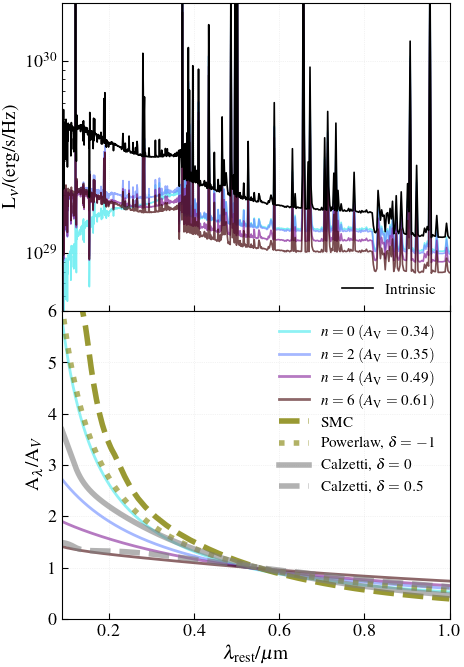

In [7]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize=(5, 8), sharex=True, sharey=False, facecolor='w', edgecolor='k')
axs = axs.ravel()

req_gal = 0

req_sed = sed_emergent[req_gal]
req_att_curve = att_curve[req_gal]
req_Av = Av[req_gal]

for ii in range(4):
    color = colors[ii]
    ok = np.where(grid.lam<=1e4 * Angstrom)[0]
    
    axs[0].plot(grid.lam[ok]/1e4, req_sed[ii].lnu[ok], color=color, alpha=0.7)
    axs[1].plot(grid.lam[ok]/1e4, req_att_curve[ii][ok]/req_Av[ii], label=rF'$n={nsigma[ii]}$ $(A_{{\rm V}}={np.round(Av[0][ii],2)})$', alpha=0.6, lw=2, color=color)    

axs[0].plot(grid.lam[ok]/1e4, sed_int[req_gal].lnu[ok], color='black', label='Intrinsic')

c = GrainModels(model='WD01', submodel='SMC')
axs[1].plot(grid.lam[ok]/1e4, c.get_tau(grid.lam[ok])/c.get_tau(5500*Angstrom), label='SMC', alpha=0.8, ls='dashed', lw=4, color='olive')

c = PowerLaw()
axs[1].plot(grid.lam[ok]/1e4, c.get_tau(grid.lam[ok])/c.get_tau(5500*Angstrom), label='Powerlaw, $\delta=-1$', alpha=0.6, ls='dotted', lw=4, color='olive')

c = Calzetti2000()
axs[1].plot(grid.lam[ok]/1e4, c.get_tau(grid.lam[ok])/c.get_tau(5500*Angstrom), label=r'Calzetti, $\delta=0$', alpha=0.6, ls='solid', lw=4, color='grey')

c = Calzetti2000(slope=0.5)
axs[1].plot(grid.lam[ok]/1e4, c.get_tau(grid.lam[ok])/c.get_tau(5500*Angstrom), label=r'Calzetti, $\delta=0.5$', alpha=0.6, ls='dashed', lw=4, color='grey')

for ax in axs:
    ax.grid(ls='dotted')
    ax.legend(frameon=False, fontsize=11) 
    ax.set_xlim(0.09,1)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(13)
    
axs[0].set_ylabel(r'L$_{\nu}$/(erg/s/Hz)', fontsize=14)
axs[0].set_ylim(5e28, 2e30)
axs[0].set_yscale('log')

axs[1].set_xlabel(r'$\lambda_{\rm rest}$/${\rm \mu m}$', fontsize=14)
axs[1].set_ylim(0,6)
axs[1].set_ylabel(r'A$_{\lambda}$/A$_{V}$', fontsize=14)

fig.subplots_adjust(hspace=0,wspace=0)   
plt.savefig('plots/toy_att_curves.png', dpi=300, bbox_inches='tight')   
plt.show()

#### Recovering SFR fraction of toy galaxies

Figure 3 in paper

<>:45: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\m'
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/1366914787.py:45: SyntaxWarning: invalid escape sequence '\m'
  twinaxs[1].legend([custom[1]], ['Varying A$_{\mathrm{V}}$ and ages'], loc='lower left', framealpha=0.2, fontsize=11,)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/1366914787.py:48: SyntaxWarning: invalid escape sequence '\m'
  twinaxs[2].legend([custom[2]], ['Varying A$_{\mathrm{V}}$ and Z'], loc='lower left', framealpha=0.2, fontsize=11)


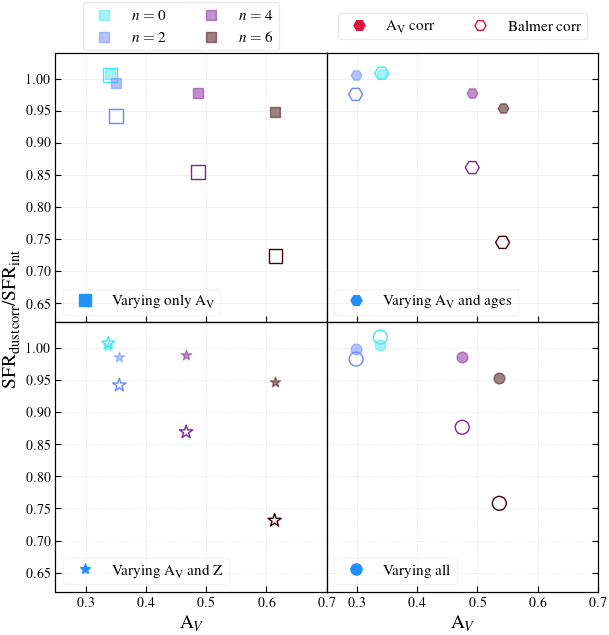

In [8]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(7, 7), facecolor='w', edgecolor='k', sharex=True, sharey=True)
axs = axs.ravel()
twinaxs = [ax.twinx() for ax in axs]

markers = ['s', 'H', '*', 'o']
custom = [Line2D([], [], marker=ii, markersize=8, color='dodgerblue', linestyle='None') for ii in markers]

custom_att = [Line2D([], [], marker='H', markersize=8, color='crimson', linestyle='None', markerfacecolor=ii) for ii in ['crimson', 'None']]

for jj in range(4):    
    for ii in range(num_gals):
        color = colors[ii] 
      
        # ax.scatter(Av[jj][ii], Halpha_frac_dust[jj][ii], color=color, s=30, marker=markers[jj], alpha=0.8, edgecolors='None')
        
        if jj==0:
            axs[jj].scatter(Av[jj][ii], Halpha_frac_Avcorr[jj][ii], color=color, s=60, marker=markers[jj], alpha=0.5, label=rF'$n={nsigma[ii]}$')
        else:
            axs[jj].scatter(Av[jj][ii], Halpha_frac_Avcorr[jj][ii], color=color, s=60, marker=markers[jj], alpha=0.5)
            
        axs[jj].scatter(Av[jj][ii], Halpha_frac_balmercorr[jj][ii], edgecolor=color, facecolor='None', s=100, marker=markers[jj])


for ax in axs:
    ax.grid(ls='dotted', alpha=0.5)
    ax.set_xticks(np.arange(0.1,1,0.1))
    ax.set_xlim(0.25,0.7)
    ax.set_ylim(0.62, 1.04)

for ax in twinaxs:
    ax.set_xlim(0.25,0.7)
    ax.set_ylim(0.62, 1.04)
    ax.set_yticks([])
    ax.set_yticklabels([])

axs[1].yaxis.tick_right()
axs[3].yaxis.tick_right()

axs[-1].set_xlabel(r'A$_{V}$', fontsize=14)
axs[-2].set_xlabel(r'A$_{V}$', fontsize=14)

twinaxs[0].legend([custom[0]], [r'Varying only A$_{\mathrm{V}}$'], loc='lower left', framealpha=0.2, fontsize=11,)
axs[0].legend(frameon=True, fontsize=11, loc=(0.1,1.01), ncols=2, framealpha=0.4)

twinaxs[1].legend([custom[1]], ['Varying A$_{\mathrm{V}}$ and ages'], loc='lower left', framealpha=0.2, fontsize=11,)
axs[1].legend(custom_att, [r'A$_{\rm V}$ corr', r'Balmer corr'], frameon=True, fontsize=11, loc=(0.04,1.05), ncols=2, framealpha=0.4)
    
twinaxs[2].legend([custom[2]], ['Varying A$_{\mathrm{V}}$ and Z'], loc='lower left', framealpha=0.2, fontsize=11)

twinaxs[3].legend([custom[3]], ['Varying all'], loc='lower left', framealpha=0.2, fontsize=11)

fig.text(0.05, 0.5, r'SFR$_{{\rm dust\, corr}}$/SFR$_{\rm int}$', va='center', fontsize=14, rotation='vertical')

# fig.tight_layout()
fig.subplots_adjust(hspace=0,wspace=0.)

plt.savefig('plots/toy_sfr_frac.png', dpi=300, bbox_inches='tight')
plt.show()   

#### Load FLARES galaxies
Convert the H-alpha luminosity (dust correct using Balmer decrement and Av) to SFR and fit Schechter function. Integrate the SFRF Schechter function to obtain the SFRD.

Plot the SFRF (Figure 4 in paper)

<>:84: SyntaxWarning: invalid escape sequence '\p'
<>:122: SyntaxWarning: invalid escape sequence '\p'
<>:163: SyntaxWarning: invalid escape sequence '\p'
<>:204: SyntaxWarning: invalid escape sequence '\p'
<>:84: SyntaxWarning: invalid escape sequence '\p'
<>:122: SyntaxWarning: invalid escape sequence '\p'
<>:163: SyntaxWarning: invalid escape sequence '\p'
<>:204: SyntaxWarning: invalid escape sequence '\p'
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:84: SyntaxWarning: invalid escape sequence '\p'
  table = [[F'{round(mu,2)} \pm {round(sig,2)}' for mu, sig in zip(mus, sigs)]]
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:122: SyntaxWarning: invalid escape sequence '\p'
  table.append([F'{round(mu,2)} \pm {round(sig,2)}' for mu, sig in zip(mus, sigs)])
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:163: SyntaxWarning: invalid escape sequence '\p'
  table.append([F'{round(mu,2)} \pm {round

Fit success 5.0,  Intrinsic: True
[[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 400000
    # data points      = 13
    # variables        = 3
    chi-square         = 52.1082962
    reduced chi-square = 5.21082962
    Akaike info crit   = 24.0488726
    Bayesian info crit = 25.7437207
    R-squared          = 0.96745676
[[Variables]]
    logLstar:    2.10668749 +/- 0.08115113 (3.85%) (init = 2.095011)
    logphistar: -4.25737796 +/- 0.12356146 (2.90%) (init = -4.240442)
    alpha:      -2.06569193 +/- 0.02713994 (1.31%) (init = -2.063222)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.9711
    C(logphistar, alpha)    = +0.8304
    C(logLstar, alpha)      = -0.6805
Fit success 5.0, Av corrected: True
[[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 400000
    # data points      = 13
    # variables        = 3
    chi-square  

/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:198: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:199: RuntimeWarning: divide by zero encountered in log10
  result = fit_schechter(np.log10(phi)[ok], bincen[ok], phi[ok], phierr[ok])


Fit success 5.0, No dust correction: True
[[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 400000
    # data points      = 12
    # variables        = 3
    chi-square         = 76.2639757
    reduced chi-square = 8.47377507
    Akaike info crit   = 28.1915284
    Bayesian info crit = 29.6462484
    R-squared          = 0.87148396
[[Variables]]
    logLstar:    1.60576839 +/- 0.03274456 (2.04%) (init = 1.603672)
    logphistar: -3.82444197 +/- 0.06928902 (1.81%) (init = -3.820018)
    alpha:      -2.14388052 +/- 0.03170049 (1.48%) (init = -2.142803)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.9315
    C(logphistar, alpha)    = +0.8904
    C(logLstar, alpha)      = -0.6843
5.0 logLstar ['2.11 \\pm 0.08' '1.89 \\pm 0.04' '1.7 \\pm 0.03' '1.61 \\pm 0.03']
5.0 logphistar ['-4.26 \\pm 0.12' '-4.1 \\pm 0.07' '-3.78 \\pm 0.06' '-3.82 \\pm 0.07']
5.0 alpha ['-2.07 \\pm 0.03' '-2.11 \\pm 0.03

/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/2592873335.py:44: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/2592873335.py:44: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfw

Fit success 6.0,  Intrinsic: True
[[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 400000
    # data points      = 13
    # variables        = 3
    chi-square         = 83.7720764
    reduced chi-square = 8.37720764
    Akaike info crit   = 30.2209549
    Bayesian info crit = 31.9158030
    R-squared          = 0.93695393
[[Variables]]
    logLstar:    2.08931948 +/- 0.08059540 (3.86%) (init = 2.075832)
    logphistar: -4.71216489 +/- 0.14859729 (3.15%) (init = -4.686072)
    alpha:      -2.26324945 +/- 0.03389945 (1.50%) (init = -2.258536)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.9699
    C(logphistar, alpha)    = +0.8568
    C(logLstar, alpha)      = -0.7127


/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:116: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:117: RuntimeWarning: divide by zero encountered in log10
  result = fit_schechter(np.log10(phi)[ok], bincen[ok], phi[ok], phierr[ok])


Fit success 6.0, Av corrected: True
[[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 400000
    # data points      = 12
    # variables        = 3
    chi-square         = 44.8472809
    reduced chi-square = 4.98303121
    Akaike info crit   = 21.8202757
    Bayesian info crit = 23.2749957
    R-squared          = 0.94394003
[[Variables]]
    logLstar:    2.29080743 +/- 0.20720432 (9.05%) (init = 2.224875)
    logphistar: -5.16711325 +/- 0.34840131 (6.74%) (init = -5.05706)
    alpha:      -2.36201027 +/- 0.03991761 (1.69%) (init = -2.351013)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.9905
    C(logphistar, alpha)    = +0.8081
    C(logLstar, alpha)      = -0.7228


/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:157: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:158: RuntimeWarning: divide by zero encountered in log10
  result = fit_schechter(np.log10(phi)[ok], bincen[ok], phi[ok], phierr[ok])


Fit success 6.0, Balmer corrected: True
[[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 400000
    # data points      = 11
    # variables        = 3
    chi-square         = 55.8212351
    reduced chi-square = 6.97765439
    Akaike info crit   = 23.8668499
    Bayesian info crit = 25.0605357
    R-squared          = 0.96296285
[[Variables]]
    logLstar:    1.80743837 +/- 0.08313415 (4.60%) (init = 1.794968)
    logphistar: -4.34280003 +/- 0.15911028 (3.66%) (init = -4.320616)
    alpha:      -2.26323474 +/- 0.04253136 (1.88%) (init = -2.258555)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.9790
    C(logphistar, alpha)    = +0.8943
    C(logLstar, alpha)      = -0.7914


/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:198: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:199: RuntimeWarning: divide by zero encountered in log10
  result = fit_schechter(np.log10(phi)[ok], bincen[ok], phi[ok], phierr[ok])


Fit success 6.0, No dust correction: True
[[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 400000
    # data points      = 10
    # variables        = 3
    chi-square         = 31.7782088
    reduced chi-square = 4.53974412
    Akaike info crit   = 17.5619570
    Bayesian info crit = 18.4697123
    R-squared          = 0.98235715
[[Variables]]
    logLstar:    1.55914725 +/- 0.05917676 (3.80%) (init = 1.550565)
    logphistar: -4.08395071 +/- 0.12711739 (3.11%) (init = -4.067065)
    alpha:      -2.29742361 +/- 0.04692600 (2.04%) (init = -2.293021)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.9689
    C(logphistar, alpha)    = +0.9038
    C(logLstar, alpha)      = -0.7807
6.0 logLstar ['2.09 \\pm 0.08' '2.29 \\pm 0.21' '1.81 \\pm 0.08' '1.56 \\pm 0.06']
6.0 logphistar ['-4.71 \\pm 0.15' '-5.17 \\pm 0.35' '-4.34 \\pm 0.16' '-4.08 \\pm 0.13']
6.0 alpha ['-2.26 \\pm 0.03' '-2.36 \\pm 0.

/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/2592873335.py:44: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/2592873335.py:44: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfw

Fit success 7.0,  Intrinsic: True
[[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 400000
    # data points      = 12
    # variables        = 3
    chi-square         = 42.5353175
    reduced chi-square = 4.72614639
    Akaike info crit   = 21.1851370
    Bayesian info crit = 22.6398569
    R-squared          = 0.93940382
[[Variables]]
    logLstar:    2.39572484 +/- 0.25438650 (10.62%) (init = 2.295096)
    logphistar: -5.67392739 +/- 0.44471202 (7.84%) (init = -5.495716)
    alpha:      -2.47877353 +/- 0.04395325 (1.77%) (init = -2.465028)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.9893
    C(logphistar, alpha)    = +0.7749
    C(logLstar, alpha)      = -0.6776


/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:116: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:117: RuntimeWarning: divide by zero encountered in log10
  result = fit_schechter(np.log10(phi)[ok], bincen[ok], phi[ok], phierr[ok])


Fit success 7.0, Av corrected: True
[[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 400000
    # data points      = 11
    # variables        = 3
    chi-square         = 21.4234231
    reduced chi-square = 2.67792788
    Akaike info crit   = 13.3324854
    Bayesian info crit = 14.5261713
    R-squared          = 0.98015235
[[Variables]]
    logLstar:    2.68029188 +/- 0.23474987 (8.76%) (init = 2.899919)
    logphistar: -6.35511786 +/- 0.41523092 (6.53%) (init = -6.73875)
    alpha:      -2.58732999 +/- 0.03714060 (1.44%) (init = -2.603934)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.9821
    C(logphistar, alpha)    = +0.6233
    C(logLstar, alpha)      = -0.4680


/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:157: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:158: RuntimeWarning: divide by zero encountered in log10
  result = fit_schechter(np.log10(phi)[ok], bincen[ok], phi[ok], phierr[ok])


Fit success 7.0, Balmer corrected: True
[[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 400000
    # data points      = 11
    # variables        = 3
    chi-square         = 53.0116703
    reduced chi-square = 6.62645878
    Akaike info crit   = 23.2987849
    Bayesian info crit = 24.4924707
    R-squared          = 0.92634301
[[Variables]]
    logLstar:    1.68941815 +/- 0.06307107 (3.73%) (init = 1.680208)
    logphistar: -4.50303649 +/- 0.14652196 (3.25%) (init = -4.481335)
    alpha:      -2.40032659 +/- 0.05064846 (2.11%) (init = -2.394596)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.9631
    C(logphistar, alpha)    = +0.8988
    C(logLstar, alpha)      = -0.7580


/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:198: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:199: RuntimeWarning: divide by zero encountered in log10
  result = fit_schechter(np.log10(phi)[ok], bincen[ok], phi[ok], phierr[ok])


Fit success 7.0, No dust correction: True
[[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 400000
    # data points      = 10
    # variables        = 3
    chi-square         = 17.4356376
    reduced chi-square = 2.49080537
    Akaike info crit   = 11.5593116
    Bayesian info crit = 12.4670668
    R-squared          = 0.96926938
[[Variables]]
    logLstar:    1.70282786 +/- 0.11386972 (6.69%) (init = 1.676218)
    logphistar: -4.76610311 +/- 0.25721293 (5.40%) (init = -4.707771)
    alpha:      -2.56760808 +/- 0.06434449 (2.51%) (init = -2.555507)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.9850
    C(logphistar, alpha)    = +0.8851
    C(logLstar, alpha)      = -0.7972
7.0 logLstar ['2.4 \\pm 0.25' '2.68 \\pm 0.23' '1.69 \\pm 0.06' '1.7 \\pm 0.11']
7.0 logphistar ['-5.67 \\pm 0.44' '-6.36 \\pm 0.42' '-4.5 \\pm 0.15' '-4.77 \\pm 0.26']
7.0 alpha ['-2.48 \\pm 0.04' '-2.59 \\pm 0.04'

/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:242: RuntimeWarning: divide by zero encountered in log10
  axs[ii].errorbar(bincen, np.log10(phi), yerr=[np.log10(phi)-np.log10(phi-phierr), np.log10(phi+phierr)-np.log10(phi)], ls='None', marker='s', color='grey', label='SFR (10 Myr)', alpha=0.9, markersize=4)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:242: RuntimeWarning: invalid value encountered in subtract
  axs[ii].errorbar(bincen, np.log10(phi), yerr=[np.log10(phi)-np.log10(phi-phierr), np.log10(phi+phierr)-np.log10(phi)], ls='None', marker='s', color='grey', label='SFR (10 Myr)', alpha=0.9, markersize=4)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:244: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:245: RuntimeWarning: divide by zero encountered i

Fit success 7.0, SFR 10Myr: True
[[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 400000
    # data points      = 12
    # variables        = 3
    chi-square         = 43.9151319
    reduced chi-square = 4.87945910
    Akaike info crit   = 21.5682276
    Bayesian info crit = 23.0229476
    R-squared          = 0.96522582
[[Variables]]
    logLstar:    2.01980798 +/- 0.09430322 (4.67%) (init = 2.001008)
    logphistar: -4.89027410 +/- 0.17023652 (3.48%) (init = -4.858637)
    alpha:      -1.86763249 +/- 0.06374132 (3.41%) (init = -1.857542)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.9464
    C(logphistar, alpha)    = +0.9173
    C(logLstar, alpha)      = -0.7680


/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/2592873335.py:44: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/2592873335.py:44: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfw

Fit success 8.0,  Intrinsic: True
[[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 400000
    # data points      = 11
    # variables        = 3
    chi-square         = 57.7185914
    reduced chi-square = 7.21482393
    Akaike info crit   = 24.2345246
    Bayesian info crit = 25.4282104
    R-squared          = 0.96975254
[[Variables]]
    logLstar:    2.44455131 +/- 0.22470768 (9.19%) (init = 2.413457)
    logphistar: -6.29371842 +/- 0.44746759 (7.11%) (init = -6.232205)
    alpha:      -2.67830591 +/- 0.04861694 (1.82%) (init = -2.677824)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.9815
    C(logphistar, alpha)    = +0.7249
    C(logLstar, alpha)      = -0.5835


/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:116: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:117: RuntimeWarning: divide by zero encountered in log10
  result = fit_schechter(np.log10(phi)[ok], bincen[ok], phi[ok], phierr[ok])


Fit success 8.0, Av corrected: True
[[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 400000
    # data points      = 11
    # variables        = 3
    chi-square         = 48.8448489
    reduced chi-square = 6.10560612
    Akaike info crit   = 22.3982902
    Bayesian info crit = 23.5919760
    R-squared          = 0.96735668
[[Variables]]
    logLstar:    2.45684976 +/- 0.19502914 (7.94%) (init = 2.543014)
    logphistar: -6.48180714 +/- 0.39906781 (6.16%) (init = -6.655112)
    alpha:      -2.75058950 +/- 0.04377744 (1.59%) (init = -2.768125)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.9776
    C(logphistar, alpha)    = +0.6541
    C(logLstar, alpha)      = -0.4839


/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:157: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:158: RuntimeWarning: divide by zero encountered in log10
  result = fit_schechter(np.log10(phi)[ok], bincen[ok], phi[ok], phierr[ok])


Fit success 8.0, Balmer corrected: True
[[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 400000
    # data points      = 11
    # variables        = 3
    chi-square         = 45.2404226
    reduced chi-square = 5.65505283
    Akaike info crit   = 21.5550529
    Bayesian info crit = 22.7487387
    R-squared          = 0.98103570
[[Variables]]
    logLstar:    2.07896759 +/- 0.18669650 (8.98%) (init = 2.016875)
    logphistar: -5.71465525 +/- 0.41840086 (7.32%) (init = -5.57539)
    alpha:      -2.70684447 +/- 0.06354698 (2.35%) (init = -2.687144)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.9886
    C(logphistar, alpha)    = +0.8567
    C(logLstar, alpha)      = -0.7733


/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:198: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:199: RuntimeWarning: divide by zero encountered in log10
  result = fit_schechter(np.log10(phi)[ok], bincen[ok], phi[ok], phierr[ok])


Fit success 8.0, No dust correction: True
[[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 400000
    # data points      = 10
    # variables        = 3
    chi-square         = 25.8767266
    reduced chi-square = 3.69667522
    Akaike info crit   = 15.5075888
    Bayesian info crit = 16.4153441
    R-squared          = 0.97993021
[[Variables]]
    logLstar:    2.01096212 +/- 0.23524629 (11.70%) (init = 1.915828)
    logphistar: -5.85191330 +/- 0.53652187 (9.17%) (init = -5.636455)
    alpha:      -2.84241161 +/- 0.07078948 (2.49%) (init = -2.820335)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.9875
    C(logphistar, alpha)    = +0.7961
    C(logLstar, alpha)      = -0.6946
8.0 logLstar ['2.44 \\pm 0.22' '2.46 \\pm 0.2' '2.08 \\pm 0.19' '2.01 \\pm 0.24']
8.0 logphistar ['-6.29 \\pm 0.45' '-6.48 \\pm 0.4' '-5.71 \\pm 0.42' '-5.85 \\pm 0.54']
8.0 alpha ['-2.68 \\pm 0.05' '-2.75 \\pm 0.0

/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:242: RuntimeWarning: divide by zero encountered in log10
  axs[ii].errorbar(bincen, np.log10(phi), yerr=[np.log10(phi)-np.log10(phi-phierr), np.log10(phi+phierr)-np.log10(phi)], ls='None', marker='s', color='grey', label='SFR (10 Myr)', alpha=0.9, markersize=4)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:242: RuntimeWarning: invalid value encountered in subtract
  axs[ii].errorbar(bincen, np.log10(phi), yerr=[np.log10(phi)-np.log10(phi-phierr), np.log10(phi+phierr)-np.log10(phi)], ls='None', marker='s', color='grey', label='SFR (10 Myr)', alpha=0.9, markersize=4)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:244: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:245: RuntimeWarning: divide by zero encountered i

Fit success 8.0, SFR 10Myr: True
[[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 400000
    # data points      = 11
    # variables        = 3
    chi-square         = 40.8426755
    reduced chi-square = 5.10533444
    Akaike info crit   = 20.4301545
    Bayesian info crit = 21.6238404
    R-squared          = 0.86507530
[[Variables]]
    logLstar:    2.14584869 +/- 0.29104055 (13.56%) (init = 2.023605)
    logphistar: -5.58814906 +/- 0.45159721 (8.08%) (init = -5.392816)
    alpha:      -2.03810868 +/- 0.09320162 (4.57%) (init = -1.994579)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.9842
    C(logphistar, alpha)    = +0.8712
    C(logLstar, alpha)      = -0.7841


/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/2592873335.py:44: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/2592873335.py:44: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfw

Fit success 9.0,  Intrinsic: True
[[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 400000
    # data points      = 11
    # variables        = 3
    chi-square         = 20.8950242
    reduced chi-square = 2.61187803
    Akaike info crit   = 13.0577736
    Bayesian info crit = 14.2514594
    R-squared          = 0.98228170
[[Variables]]
    logLstar:    2.31890821 +/- 0.14027480 (6.05%) (init = 2.490237)
    logphistar: -6.60962478 +/- 0.32341857 (4.89%) (init = -7)
    alpha:      -2.88786543 +/- 0.05055308 (1.75%) (init = -2.926909)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.9602
    C(logphistar, alpha)    = +0.6690
    C(logLstar, alpha)      = -0.4400


/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:116: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:117: RuntimeWarning: divide by zero encountered in log10
  result = fit_schechter(np.log10(phi)[ok], bincen[ok], phi[ok], phierr[ok])
/Users/ap629AA/pyvenv/astro_venv/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Fit success 9.0, Av corrected: True
[[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 400000
    # data points      = 11
    # variables        = 3
    chi-square         = 14.8407005
    reduced chi-square = 1.85508756
    Akaike info crit   = 9.29425984
    Bayesian info crit = 10.4879457
    R-squared          = 0.98990374
[[Variables]]
    logLstar:    2.29865584 +/- 0.14469542 (6.29%) (init = 2.468486)
    logphistar: -6.62381845 +/- 0.32654771 (4.93%) (init = -7)
    alpha:      -2.90507793 +/- 0.05323275 (1.83%) (init = -2.938148)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.9528
    C(logphistar, alpha)    = +0.5805
    C(logLstar, alpha)      = -0.3111


/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:157: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:158: RuntimeWarning: divide by zero encountered in log10
  result = fit_schechter(np.log10(phi)[ok], bincen[ok], phi[ok], phierr[ok])


Fit success 9.0, Balmer corrected: True
[[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 400000
    # data points      = 10
    # variables        = 3
    chi-square         = 17.6943218
    reduced chi-square = 2.52776025
    Akaike info crit   = 11.7065869
    Bayesian info crit = 12.6143422
    R-squared          = 0.97757648
[[Variables]]
    logLstar:    2.24745196 +/- 0.17204441 (7.66%) (init = 2.428294)
    logphistar: -6.51673027 +/- 0.38931408 (5.97%) (init = -6.925526)
    alpha:      -2.91104463 +/- 0.05361286 (1.84%) (init = -2.948397)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.9728
    C(logphistar, alpha)    = +0.6697
    C(logLstar, alpha)      = -0.4841


/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:198: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:199: RuntimeWarning: divide by zero encountered in log10
  result = fit_schechter(np.log10(phi)[ok], bincen[ok], phi[ok], phierr[ok])


Fit success 9.0, No dust correction: True
[[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 400000
    # data points      = 10
    # variables        = 3
    chi-square         = 13.4881004
    reduced chi-square = 1.92687149
    Akaike info crit   = 8.99222755
    Bayesian info crit = 9.89998283
    R-squared          = 0.97258969
[[Variables]]
    logLstar:    1.87462766 +/- 0.22010144 (11.74%) (init = 1.792976)
    logphistar: -5.95662243 +/- 0.55533568 (9.32%) (init = -5.752752)
    alpha:      -2.99218708 +/- 0.08911165 (2.98%) (init = -2.970796)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.9829
    C(logphistar, alpha)    = +0.8000
    C(logLstar, alpha)      = -0.6807
9.0 logLstar ['2.32 \\pm 0.14' '2.3 \\pm 0.14' '2.25 \\pm 0.17' '1.87 \\pm 0.22']
9.0 logphistar ['-6.61 \\pm 0.32' '-6.62 \\pm 0.33' '-6.52 \\pm 0.39' '-5.96 \\pm 0.56']
9.0 alpha ['-2.89 \\pm 0.05' '-2.91 \\pm 0.

/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:242: RuntimeWarning: divide by zero encountered in log10
  axs[ii].errorbar(bincen, np.log10(phi), yerr=[np.log10(phi)-np.log10(phi-phierr), np.log10(phi+phierr)-np.log10(phi)], ls='None', marker='s', color='grey', label='SFR (10 Myr)', alpha=0.9, markersize=4)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:242: RuntimeWarning: invalid value encountered in subtract
  axs[ii].errorbar(bincen, np.log10(phi), yerr=[np.log10(phi)-np.log10(phi-phierr), np.log10(phi+phierr)-np.log10(phi)], ls='None', marker='s', color='grey', label='SFR (10 Myr)', alpha=0.9, markersize=4)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:244: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:245: RuntimeWarning: divide by zero encountered i

Fit success 9.0, SFR 10Myr: True
[[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 400000
    # data points      = 12
    # variables        = 3
    chi-square         = 21.5150229
    reduced chi-square = 2.39055810
    Akaike info crit   = 13.0061373
    Bayesian info crit = 14.4608573
    R-squared          = 0.92496903
[[Variables]]
    logLstar:    2.02469429 +/- 0.15030783 (7.42%) (init = 1.980012)
    logphistar: -5.78483258 +/- 0.33144475 (5.73%) (init = -5.688842)
    alpha:      -2.09227199 +/- 0.11465405 (5.48%) (init = -2.059919)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.9571
    C(logphistar, alpha)    = +0.9066
    C(logLstar, alpha)      = -0.7737


/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/2592873335.py:44: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/2592873335.py:44: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfw

Fit success 10.0,  Intrinsic: True
[[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 400000
    # data points      = 10
    # variables        = 3
    chi-square         = 32.5514601
    reduced chi-square = 4.65020858
    Akaike info crit   = 17.8023713
    Bayesian info crit = 18.7101266
    R-squared          = 0.93805275
[[Variables]]
    logLstar:    2.19247857 +/- 0.12825667 (5.85%) (init = 2.33185)
    logphistar: -6.67609038 +/- 0.29191884 (4.37%) (init = -7)
    alpha:      -2.94626227 +/- 0.06338355 (2.15%) (init = -2.98488)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.9250
    C(logphistar, alpha)    = +0.5215
    C(logLstar, alpha)      = -0.1650


/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:116: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:117: RuntimeWarning: divide by zero encountered in log10
  result = fit_schechter(np.log10(phi)[ok], bincen[ok], phi[ok], phierr[ok])
/Users/ap629AA/pyvenv/astro_venv/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Fit success 10.0, Av corrected: True
[[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 400000
    # data points      = 10
    # variables        = 3
    chi-square         = 22.3663914
    reduced chi-square = 3.19519877
    Akaike info crit   = 14.0497436
    Bayesian info crit = 14.9574988
    R-squared          = 0.95230744
[[Variables]]
    logLstar:    2.11254827 +/- 0.12362949 (5.85%) (init = 2.249871)
    logphistar: -6.66575446 +/- 0.29668802 (4.45%) (init = -7)
    alpha:      -3.02876035 +/- 0.06506788 (2.15%) (init = -3.068306)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.9289
    C(logphistar, alpha)    = +0.5182
    C(logLstar, alpha)      = -0.1717


/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:157: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:158: RuntimeWarning: divide by zero encountered in log10
  result = fit_schechter(np.log10(phi)[ok], bincen[ok], phi[ok], phierr[ok])


Fit success 10.0, Balmer corrected: True
[[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 400000
    # data points      = 10
    # variables        = 3
    chi-square         = 24.7613303
    reduced chi-square = 3.53733289
    Akaike info crit   = 15.0669808
    Bayesian info crit = 15.9747361
    R-squared          = 0.94002986
[[Variables]]
    logLstar:    1.83226754 +/- 0.19759431 (10.78%) (init = 1.772738)
    logphistar: -6.06616619 +/- 0.51331042 (8.46%) (init = -5.913981)
    alpha:      -3.02632775 +/- 0.09080771 (3.00%) (init = -3.012314)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.9804
    C(logphistar, alpha)    = +0.8044
    C(logLstar, alpha)      = -0.6772


/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:198: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:199: RuntimeWarning: divide by zero encountered in log10
  result = fit_schechter(np.log10(phi)[ok], bincen[ok], phi[ok], phierr[ok])


Fit success 10.0, No dust correction: True
[[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 400000
    # data points      = 9
    # variables        = 3
    chi-square         = 22.9606235
    reduced chi-square = 3.82677058
    Akaike info crit   = 14.4290053
    Bayesian info crit = 15.0206791
    R-squared          = 0.94078607
[[Variables]]
    logLstar:    1.58027430 +/- 0.19475480 (12.32%) (init = 1.514458)
    logphistar: -5.65325377 +/- 0.56252632 (9.95%) (init = -5.461789)
    alpha:      -3.09603262 +/- 0.12929205 (4.18%) (init = -3.053463)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.9869
    C(logphistar, alpha)    = +0.8777
    C(logLstar, alpha)      = -0.7956
10.0 logLstar ['2.19 \\pm 0.13' '2.11 \\pm 0.12' '1.83 \\pm 0.2' '1.58 \\pm 0.19']
10.0 logphistar ['-6.68 \\pm 0.29' '-6.67 \\pm 0.3' '-6.07 \\pm 0.51' '-5.65 \\pm 0.56']
10.0 alpha ['-2.95 \\pm 0.06' '-3.03 \\pm 

/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:242: RuntimeWarning: divide by zero encountered in log10
  axs[ii].errorbar(bincen, np.log10(phi), yerr=[np.log10(phi)-np.log10(phi-phierr), np.log10(phi+phierr)-np.log10(phi)], ls='None', marker='s', color='grey', label='SFR (10 Myr)', alpha=0.9, markersize=4)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:242: RuntimeWarning: invalid value encountered in subtract
  axs[ii].errorbar(bincen, np.log10(phi), yerr=[np.log10(phi)-np.log10(phi-phierr), np.log10(phi+phierr)-np.log10(phi)], ls='None', marker='s', color='grey', label='SFR (10 Myr)', alpha=0.9, markersize=4)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:244: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_71003/263342686.py:245: RuntimeWarning: divide by zero encountered i

Fit success 10.0, SFR 10Myr: True
[[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 400000
    # data points      = 11
    # variables        = 3
    chi-square         = 32.2603030
    reduced chi-square = 4.03253787
    Akaike info crit   = 17.8353641
    Bayesian info crit = 19.0290499
    R-squared          = 0.85140449
[[Variables]]
    logLstar:    2.19858931 +/- 0.11262641 (5.12%) (init = 2.306983)
    logphistar: -6.78348224 +/- 0.20043982 (2.95%) (init = -7)
    alpha:      -2.36867612 +/- 0.08280756 (3.50%) (init = -2.4227)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.7991
    C(logphistar, alpha)    = +0.5641


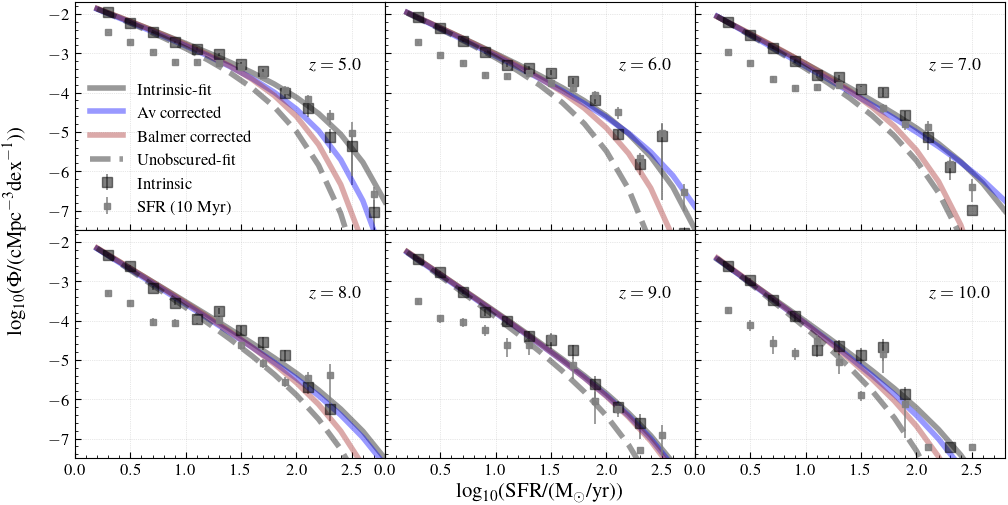

In [9]:
h = 0.6777
vol = (4/3)*np.pi*(14/h)**3
quantiles = [0.16,0.50,0.84]
df = pd.read_csv('./data/weights_grid.txt')
weights = np.array(df['weights'])

sfrbins = np.arange(0.2, 2.91, 0.2)
bincen = (sfrbins[1:]+sfrbins[:-1])/2.
binwidth = sfrbins[1:] - sfrbins[:-1]

sfrbinslow = np.arange(0.5, 2.91, 0.2)
sfrbinshigh = np.arange(1.5, 2.91, 0.2)

tags = ['010_z005p000', '009_z006p000', '008_z007p000', '007_z008p000', '006_z009p000', '005_z010p000']

int_frac = np.zeros((2, len(tags)))
int_frac_err = np.zeros((2, len(tags)))

obsc_frac = np.zeros((2, len(tags)))
obsc_frac_err = np.zeros((2, len(tags)))

sfrd_frac_Av = np.zeros((2, len(tags)))
sfrd_frac_Av_err = np.zeros((2, len(tags)))

sfrd_frac_balmer = np.zeros((2, len(tags)))
sfrd_frac_balmer_err = np.zeros((2, len(tags)))

fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(12, 6), sharex=True, sharey=True, facecolor='w', edgecolor='k')
axs = axs.ravel()

# Fit parameter order
param_order = ['logLstar', 'logphistar', 'alpha']

for ii, tag in enumerate(tags):
       
    z = float(tag[5:].replace('p','.'))

    func    = partial(get_data, tag=tag)
    pool    = MultiPool(processes=4)
    dat     = np.array(list(pool.map(func, np.arange(0,40))), dtype='object')
    pool.close()

    Mstar = np.log10(np.concatenate(dat[:,0]))
    MFUVatt = np.concatenate(dat[:,1])
    Halpha = np.concatenate(dat[:,2])
    Hbeta = np.concatenate(dat[:,3])
    Halphaint = np.concatenate(dat[:,4])
    Hbetaint = np.concatenate(dat[:,5])
    MassweightedZ = np.concatenate(dat[:,6])
    MFUVint = np.concatenate(dat[:,7])
    Av = np.concatenate(dat[:,8])
    SFR10 = np.concatenate(dat[:,9])
    
    Halpha_Av = calc_line_corr_from_Av(Halpha * erg/s, lam_Ha, Av, slope=0).to_value()
    Halpha_balmer =  calc_line_corr(Halpha * erg/s, lam_Ha, Halpha/Hbeta, slope=0).to_value() 
    
    sfr_int = np.log10(Ha_to_SFR(Halphaint))
    sfr_dust = np.log10(Ha_to_SFR(Halpha))
    sfr_Av = np.log10(Ha_to_SFR(Halpha_Av))
    sfr_balmer = np.log10(Ha_to_SFR(Halpha_balmer))
    
    sfr10_int = np.log10(SFR10)
       
    tot_gals = len(Mstar)
    
    n = np.array([])
    for jj in range(40):
        n = np.append(n, len(dat[jj][0]))

    #Make the SFR distribution function, integrate the different ratio to get the recovered fraction  
     
    #Intrinsic
    hist, M, err = get_flares_LF(sfr_int, weights, sfrbins, n)
    ok = np.where(hist>=5)[0]
    phi, phierr = M/(binwidth*vol), err/(binwidth*vol)
    axs[ii].errorbar(bincen, np.log10(phi), yerr=[np.log10(phi)-np.log10(phi-phierr), np.log10(phi+phierr)-np.log10(phi)], ls='None', marker='s', color='black', label='Intrinsic', alpha=0.5, markersize=7)
    
    ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)
    result = fit_schechter(np.log10(phi)[ok], bincen[ok], phi[ok], phierr[ok])            
    print(f"Fit success {z},  Intrinsic: {result.success}")
    print(result.fit_report())    
    mus = np.array([result.params[p].value for p in param_order])
    sigs = np.array([result.params[p].stderr for p in param_order])
    table = [[F'{round(mu,2)} \pm {round(sig,2)}' for mu, sig in zip(mus, sigs)]]
    
    cov = result.flatchain[param_order].cov().values
    # MC Integration for SFR Density
    rho_mean, rho_std, _ = schechter_mass_density_MC(
        N_MC=10000,
        mu=mus,
        cov=cov,
        logL_min=0.0,   
        logL_max=3.5,  
        M=50
    )
    tot = unumpy.uarray(rho_mean, rho_std)
    rho_mean, rho_std, _ = schechter_mass_density_MC(
        N_MC=10000,
        mu=mus,
        cov=cov,
        logL_min=1.5,   
        logL_max=3.5,  
        M=30
    )
    tothigh = unumpy.uarray(rho_mean, rho_std)

    f = schechter_fn(sfrbins, mus[0], mus[1], mus[2])
    axs[ii].plot(sfrbins, f, lw=4, alpha=0.4, ls='solid', label='Intrinsic-fit', color='black')    
       
    
    # Av Corrected
    hist, M, err = get_flares_LF(sfr_Av, weights, sfrbins, n)
    ok = np.where(hist>=5)[0]
    phi, phierr = M/(binwidth*vol), err/(binwidth*vol)

    ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)
    result = fit_schechter(np.log10(phi)[ok], bincen[ok], phi[ok], phierr[ok])            
    print(f"Fit success {z}, Av corrected: {result.success}")
    print(result.fit_report())    
    mus = np.array([result.params[p].value for p in param_order])
    sigs = np.array([result.params[p].stderr for p in param_order])
    table.append([F'{round(mu,2)} \pm {round(sig,2)}' for mu, sig in zip(mus, sigs)]) 
    cov = result.flatchain[param_order].cov().values
    # MC Integration for SFR Density
    rho_mean, rho_std, _ = schechter_mass_density_MC(
        N_MC=10000,
        mu=mus,
        cov=cov,
        logL_min=0.0,   
        logL_max=3.5,  
        M=50
    )
    tmp = unumpy.uarray(rho_mean, rho_std) / tot
    sfrd_frac_Av[0][ii] = unumpy.nominal_values(tmp)
    sfrd_frac_Av_err[0][ii] = unumpy.std_devs(tmp)
    rho_mean, rho_std, _ = schechter_mass_density_MC(
        N_MC=10000,
        mu=mus,
        cov=cov,
        logL_min=1.5,   
        logL_max=3.5,  
        M=30
    )
    tmp = unumpy.uarray(rho_mean, rho_std) / tothigh
    sfrd_frac_Av[1][ii] = unumpy.nominal_values(tmp)
    sfrd_frac_Av_err[1][ii] = unumpy.std_devs(tmp)
    
    f = schechter_fn(sfrbins, mus[0], mus[1], mus[2])
    axs[ii].plot(sfrbins, f, lw=4, alpha=0.4, ls='solid', label='Av corrected', color='blue')  
        
    
    # Balmer Corrected
    hist, M, err = get_flares_LF(sfr_balmer, weights, sfrbins, n)
    ok = np.where(hist>=5)[0]
    phi, phierr = M/(binwidth*vol), err/(binwidth*vol)

    ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)
    result = fit_schechter(np.log10(phi)[ok], bincen[ok], phi[ok], phierr[ok])            
    print(f"Fit success {z}, Balmer corrected: {result.success}")
    print(result.fit_report())    
    mus = np.array([result.params[p].value for p in param_order])
    sigs = np.array([result.params[p].stderr for p in param_order])
    table.append([F'{round(mu,2)} \pm {round(sig,2)}' for mu, sig in zip(mus, sigs)]) 
    cov = result.flatchain[param_order].cov().values
    # MC Integration for SFR Density
    rho_mean, rho_std, _ = schechter_mass_density_MC(
        N_MC=10000,
        mu=mus,
        cov=cov,
        logL_min=0.0,   
        logL_max=3.5,  
        M=50
    )
    tmp = unumpy.uarray(rho_mean, rho_std) / tot
    sfrd_frac_balmer[0][ii] = unumpy.nominal_values(tmp)
    sfrd_frac_balmer_err[0][ii] = unumpy.std_devs(tmp)
    rho_mean, rho_std, _ = schechter_mass_density_MC(
        N_MC=10000,
        mu=mus,
        cov=cov,
        logL_min=1.5,   
        logL_max=3.5,  
        M=30
    )
    tmp = unumpy.uarray(rho_mean, rho_std) / tothigh
    sfrd_frac_balmer[1][ii] = unumpy.nominal_values(tmp)
    sfrd_frac_balmer_err[1][ii] = unumpy.std_devs(tmp)
    
    f = schechter_fn(sfrbins, mus[0], mus[1], mus[2])
    axs[ii].plot(sfrbins, f, lw=4, alpha=0.4, ls='solid', label='Balmer corrected', color='brown') 
    
    
    # Unobscured, no dust correction
    hist, M, err = get_flares_LF(sfr_dust, weights, sfrbins, n)
    ok = np.where(hist>=5)[0]
    phi, phierr = M/(binwidth*vol), err/(binwidth*vol)
    # # axs[ii].plot(bincen, np.log10(phi), lw=4, alpha=0.4, ls='dashed', label='Observed', color='black')
    ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)
    result = fit_schechter(np.log10(phi)[ok], bincen[ok], phi[ok], phierr[ok])            
    print(f"Fit success {z}, No dust correction: {result.success}")
    print(result.fit_report())    
    mus = np.array([result.params[p].value for p in param_order])
    sigs = np.array([result.params[p].stderr for p in param_order])
    table.append([F'{round(mu,2)} \pm {round(sig,2)}' for mu, sig in zip(mus, sigs)]) 
    cov = result.flatchain[param_order].cov().values
    # MC Integration for SFR Density
    rho_mean, rho_std, _ = schechter_mass_density_MC(
        N_MC=10000,
        mu=mus,
        cov=cov,
        logL_min=0.0,   
        logL_max=3.5,  
        M=50
    )
    tmp = unumpy.uarray(rho_mean, rho_std) / tot
    obsc_frac[0][ii] = unumpy.nominal_values(tmp)
    obsc_frac_err[0][ii] = unumpy.std_devs(tmp)
    rho_mean, rho_std, _ = schechter_mass_density_MC(
        N_MC=10000,
        mu=mus,
        cov=cov,
        logL_min=1.5,   
        logL_max=3.5,  
        M=30
    )
    tmp = unumpy.uarray(rho_mean, rho_std) / tothigh
    obsc_frac[1][ii] = unumpy.nominal_values(tmp)
    obsc_frac_err[1][ii] = unumpy.std_devs(tmp)
    
    f = schechter_fn(sfrbins, mus[0], mus[1], mus[2])
    axs[ii].plot(sfrbins, f, lw=4, alpha=0.4, ls='dashed', label='Unobscured-fit', color='black')  

    table = np.array(table)
    print(F'{z} {param_order[0]}', table[:,0])   
    print(F'{z} {param_order[1]}', table[:,1])   
    print(F'{z} {param_order[2]}', table[:,2])    
    
    # SFR (10 Myr)
    hist, M, err = get_flares_LF(sfr10_int, weights, sfrbins, n)
    ok = np.where(hist>=5)[0]
    phi, phierr = M/(binwidth*vol), err/(binwidth*vol)
    axs[ii].errorbar(bincen, np.log10(phi), yerr=[np.log10(phi)-np.log10(phi-phierr), np.log10(phi+phierr)-np.log10(phi)], ls='None', marker='s', color='grey', label='SFR (10 Myr)', alpha=0.9, markersize=4)
    
    ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)
    result = fit_schechter(np.log10(phi)[ok], bincen[ok], phi[ok], phierr[ok])            
    print(f"Fit success {z}, SFR 10Myr: {result.success}")
    print(result.fit_report())    
    mus = np.array([result.params[p].value for p in param_order])
    cov = result.flatchain[param_order].cov().values
    # MC Integration for SFR Density
    rho_mean, rho_std, _ = schechter_mass_density_MC(
        N_MC=10000,
        mu=mus,
        cov=cov,
        logL_min=0.0,   
        logL_max=3.5,  
        M=50
    )
    tmp = unumpy.uarray(rho_mean, rho_std) / tot
    int_frac[0][ii] = unumpy.nominal_values(tmp)
    int_frac_err[0][ii] = unumpy.std_devs(tmp)
    rho_mean, rho_std, _ = schechter_mass_density_MC(
        N_MC=10000,
        mu=mus,
        cov=cov,
        logL_min=1.5,   
        logL_max=3.5,  
        M=30
    )
    tmp = unumpy.uarray(rho_mean, rho_std) / tothigh
    int_frac[1][ii] = unumpy.nominal_values(tmp)
    int_frac_err[1][ii] = unumpy.std_devs(tmp)
   
    axs[ii].text(2.1, -3.4, r'$z = {}$'.format(z), fontsize = 13)
    
for ax in axs:
    ax.grid(True, alpha=0.6, ls='dotted')
    ax.set_xlim(0., 2.8)
    ax.set_ylim(-7.5, -1.7)
    ax.minorticks_on()
    ax.tick_params(axis='x', which='minor', direction='in')
    ax.tick_params(axis='y', which='minor', direction='in')
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(12)

axs[0].legend(frameon=False, fontsize=12)
axs[4].set_xlabel(r'log$_{10}$($\mathrm{SFR}$/(M$_{\odot}$/yr))', fontsize=15)

fig.subplots_adjust(bottom=0.12, wspace=0, hspace=0)

fig.text(0.065, 0.5, r'log$_{10}$($\Phi$/($\mathrm{cMpc}^{-3}\mathrm{dex}^{-1}$))', va='center', rotation='vertical', fontsize=15)

plt.savefig('plots/sfr_function.png', dpi=300, bbox_inches='tight')

#### Plot the SFRD fractions across redshift z=5-10

Figure 5 in paper

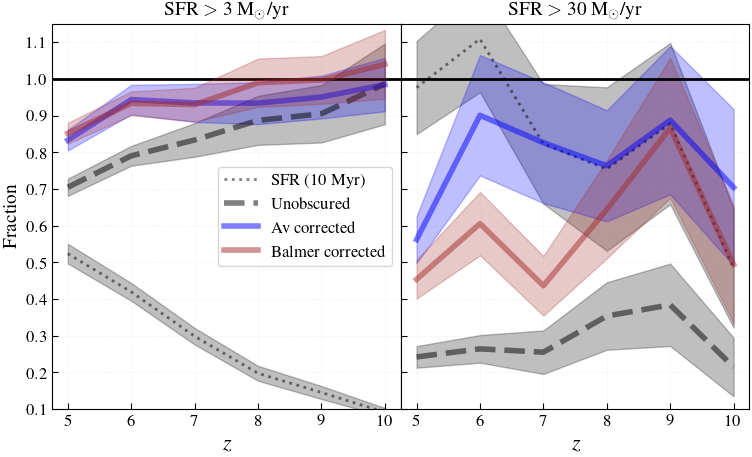

In [10]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(9, 5), sharex=True, sharey=True, facecolor='w', edgecolor='k')
axs = axs.ravel()

zs = np.arange(5,11,1)

axs[0].plot(zs, int_frac[0], color='black', label='SFR (10 Myr)', ls='dotted', lw=2, alpha=0.5)
axs[0].fill_between(zs, int_frac[0]-int_frac_err[0], int_frac[0]+int_frac_err[0], alpha=0.25, color='black')

axs[0].plot(zs, obsc_frac[0], color='black', label='Unobscured', ls='dashed', lw=4, alpha=0.5)
axs[0].fill_between(zs, obsc_frac[0]-obsc_frac_err[0], obsc_frac[0]+obsc_frac_err[0], alpha=0.25, color='black')

axs[0].plot(zs, sfrd_frac_Av[0], color='blue', label='Av corrected', lw=4, alpha=0.5)
axs[0].fill_between(zs, sfrd_frac_Av[0]-sfrd_frac_Av_err[0], sfrd_frac_Av[0]+sfrd_frac_Av_err[0], alpha=0.25, color='blue')

axs[0].plot(zs, sfrd_frac_balmer[0], color='brown', label='Balmer corrected', lw=4, alpha=0.5, zorder=10)
axs[0].fill_between(zs, sfrd_frac_balmer[0]-sfrd_frac_balmer_err[0], sfrd_frac_balmer[0]+sfrd_frac_balmer_err[0], alpha=0.25, color='brown', zorder=10)


axs[1].plot(zs, int_frac[1], color='black', ls='dotted', lw=2, alpha=0.5)
axs[1].fill_between(zs, int_frac[1]-int_frac_err[1], int_frac[1]+int_frac_err[1], alpha=0.25, color='black')

axs[1].plot(zs, obsc_frac[1], color='black', ls='dashed', lw=4, alpha=0.5)
axs[1].fill_between(zs, obsc_frac[1]-obsc_frac_err[1], obsc_frac[1]+obsc_frac_err[1], alpha=0.25, color='black')

axs[1].plot(zs, sfrd_frac_Av[1], color='blue', lw=4, alpha=0.5)
axs[1].fill_between(zs, sfrd_frac_Av[1]-sfrd_frac_Av_err[1], sfrd_frac_Av[1]+sfrd_frac_Av_err[1], alpha=0.25, color='blue')

axs[1].plot(zs, sfrd_frac_balmer[1], color='brown', lw=4, alpha=0.5)
axs[1].fill_between(zs, sfrd_frac_balmer[1]-sfrd_frac_balmer_err[1], sfrd_frac_balmer[1]+sfrd_frac_balmer_err[1], alpha=0.25, color='brown')

axs[0].legend(fontsize=12, frameon=True)

for ax in axs:
    ax.axhline(y=1.0, color='black', lw=2)
    ax.grid(ls='dotted')
    ax.set_ylim(0.1, 1.15)
    ax.set_yticks(np.arange(0.1, 1.16, 0.1))
    ax.set_xlabel(r'$z$', fontsize=16)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(12)

axs[0].set_ylabel('Fraction', fontsize=14)
axs[0].set_title(r'SFR $>$ 3 M$_{\odot}$/yr', fontsize=14)   
axs[1].set_title(r'SFR $>$ 30 M$_{\odot}$/yr', fontsize=14)   

fig.subplots_adjust(hspace=0,wspace=0)
plt.savefig('plots/sfrd_frac.png', dpi=300, bbox_inches='tight')